In [1]:
import sys,glob,datetime,os,gc,importlib,pickle,cftime,re,string
import xarray as xr
import numpy as np
import pandas as pd

import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
from distinctipy import distinctipy
from matplotlib.backends.backend_pdf import PdfPages

import cartopy

import itertools
import warnings
warnings.filterwarnings("ignore")

ERROR 1: PROJ: proj_create_from_database: Open of /home/u/u290372/.conda/envs/py_main/share/proj failed


In [2]:
try:
    %matplotlib inline
    indicator = 'tas'
    %load_ext autoreload
    %autoreload 2
except:
    import argparse
    parser = argparse.ArgumentParser(description='look it up')
    parser.add_argument('-i', '--indicator')  
    args = vars(parser.parse_args())
    print(args)
    indicator = args['indicator']    

In [3]:
sys.path.append('/home/u/u290372/scripts/')
from cartopy_features import *
import _regions_ar6wg1 
sys.path.append('/home/u/u290372/scripts/cmip6_ensemble_scripts')
import _paths as _paths; importlib.reload(_paths)
import _regTS_ensemble as _regTS_ensemble

In [4]:
co2_data = pd.read_table('/work/uc1275/u290372/overshoot/emissions_CO2.csv', sep=',')
ch4_data = pd.read_table('/work/uc1275/u290372/overshoot/emissions_CH4.csv', sep=',')
co2_data

,Model,Scenario,Region,Variable,Unit,2015,2020,2030,2040,2050,2060,2070,2080,2090,2100,Notes
0,IMAGE,SSP1-19,World,CMIP6 Emissions|CO2,Mt CO2/yr,"39152,726","39693,726","22847,271","10475,089","2050,362","-1525,978","-4476,970","-7308,783","-10565,023","-13889,788",NaN
1,REMIND-MAGPIE,SSP5-34-OS,World,CMIP6 Emissions|CO2,Mt CO2/yr,"39152,726","43712,629","55300,017","68774,628","50319,095","16582,668","-5768,062","-14855,333","-18556,245","-20311,382",NaN
2,© SSP Public Database (Version 2.0) https://t...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,For recommended citation please follow this li...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
oo = _regTS_ensemble.regTS_ensemble(region_name='MED-land', realm='Amon', indicator='tas', scenario='*', esm='*', run='*')
oo.load_existing_object()
oo.adjust_gmt()

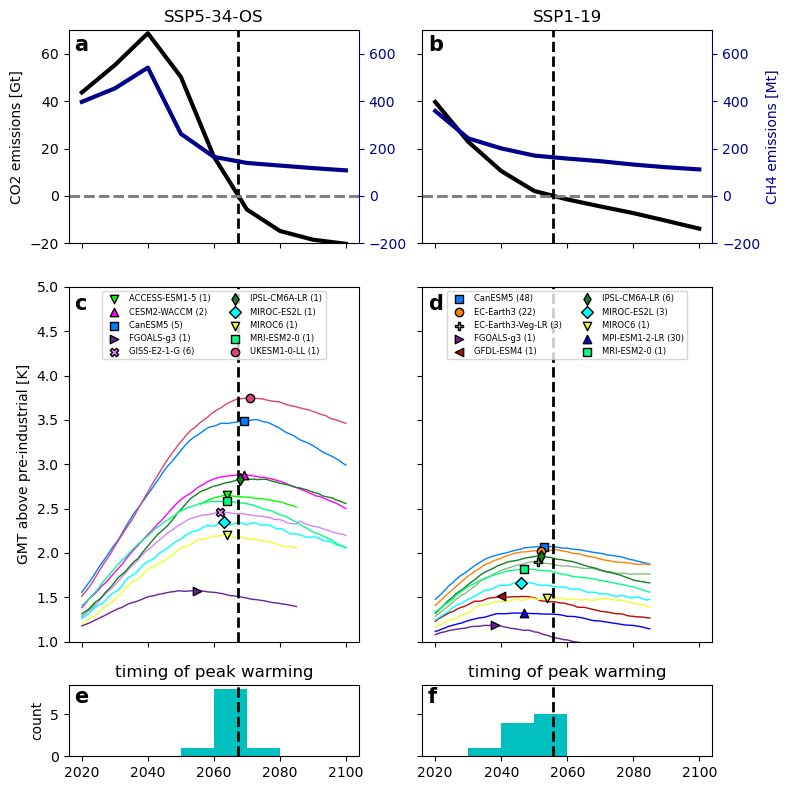

In [16]:
fig,axes = plt.subplots(nrows=3, ncols=2, figsize=(8,8), sharex=True, sharey='row', gridspec_kw=dict(height_ratios=[3,5,1]), dpi=100)

for col,scG,scE in zip([0,1],['ssp534-over','ssp119'], ['SSP5-34-OS', 'SSP1-19']):
    ax1 = axes[0,col]
    ax1.set_title(scE)
    ax2 = ax1.twinx()
    ax1.set_ylim(-20,70)
    ax2.set_ylim(-200,700)
    ax1.set_frame_on(False)
    ax2.spines['left'].set_color('black')
    ax1.yaxis.label.set_color('black')
    ax1.tick_params(axis='y', colors='black')
    ax2.spines['right'].set_color('darkblue')
    ax2.yaxis.label.set_color('darkblue')
    ax2.tick_params(axis='y', colors='darkblue')
    if col == 0:
        ax1.set_ylabel('CO2 emissions [Gt]')
    if col == 1:
        ax2.set_ylabel('CH4 emissions [Mt]')

    for ax,data,color,div in zip([ax1,ax2], [co2_data,ch4_data], ['black','darkblue'],[10**3,1]):
        ax.axhline(0, color='gray', lw=2, ls='--')
        c = data.loc[data.Scenario == scE].iloc[:,6:-1].T
        y = np.array([v.replace(',','.') for v in c.values[:,0]], 'float') / div
        years = np.array(c.index.values, 'float')
        ax.plot(years, y, color=color, linewidth=3, zorder=10) 
        if y[-1] < 0:
            bp = np.where(y > 0)[0][-1]
            netzero = years[bp] - y[bp] * (years[bp+1] - years[bp]) / (y[bp+1] - y[bp])
            for ax_ in axes[:,col]:
                ax_.axvline(netzero, color=color, lw=2, ls='--')


    axG = axes[1,col]
    peak_years = []
    for model in oo._models:
        SMRs = oo.get_smrs_for_scenario_model(scG, model)
        n = len(SMRs)
        if np.isfinite(n):
            if n > 0:
                gmt = oo._gmt.loc[SMRs]
                gmt = gmt.rolling(year=oo._rolling_mean_window, center=True).mean('year').median('SMR').loc[2020:2100]
                axG.plot(gmt.year, gmt, color=oo._color_d[model], linewidth=1, zorder=1)
                peak_year = oo._peak_years.loc[SMRs].values.mean().round()
                axG.scatter(peak_year, gmt.loc[peak_year], color=oo._color_d[model], marker=oo._marker_d[model], edgecolor='k', 
                            label='%s (%s)' %(model, n), zorder=2)            
                peak_years.append(peak_year)

    axes[2,col].set_title('timing of peak warming')
    _ = axes[2,col].hist(peak_years, bins=np.arange(2020,2100,10), color='c')

    #axes[1,col].axis('off')
    axG.legend(loc='upper center', ncol=2, fontsize=6).set_zorder(3)
    
for ax,l in zip(axes.flatten(), string.ascii_lowercase):
    ax.annotate(l, xy=(0.02,0.98), xycoords='axes fraction', ha='left', va='top', fontsize=15, fontweight='bold')
axG.set_ylim(1,5)
axes[1,0].set_ylabel('GMT above pre-industrial [K]')
axes[2,0].set_ylabel('count')
plt.tight_layout()
plt.savefig('/work/uc1275/u290372/overshoot/plots/explainer/emissions_gmt_peak_timing.png',  bbox_inches='tight', dpi=300)